### Introduction:

This notebook is also available in Github under: https://github.com/MedGhassen/DTSA-5510-Unsupervised-Learning-Final-Project-

#### Brief description of the dataset:
The dataset in question is a well-known resource from Kaggle, titled "Credit Card Fraud Detection". It comprises transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, with the positive class (frauds) accounting for only 0.172% of all transactions.

Each transaction is described by 30 features, with 28 of them being the result of a Principal Component Analysis (PCA) transformation (due to confidentiality issues, actual feature names and background details about the data are not provided). The only features which have not been transformed with PCA are 'Time' and 'Amount'. 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the transaction Amount. The 'Class' feature is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The dataset is available under: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

#### Statement of the unsupervised learning problem:
In the context of this dataset, the unsupervised learning problem is to identify fraudulent credit card transactions using methods that do not rely on labeled data. Since the dataset is predominantly composed of non-fraudulent transactions, traditional supervised learning approaches might not be effective due to the severe class imbalance. Instead, unsupervised learning techniques such as clustering, anomaly detection, or dimensionality reduction can be applied to discern patterns or anomalies indicative of fraud without the need for labeled training data. These methods can help in discovering hidden structures within the data, identifying suspicious transactions, and ultimately, aiding in the development of systems to flag or prevent potential fraud in future transactions. The challenge lies in accurately distinguishing between legitimate and fraudulent transactions based on the features available, without the guidance of a pre-labeled target variable.

## Data Gathering

The following Code is copied from Kaggel

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'creditcardfraud:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F310%2F23498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240305%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240305T145247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da387c7eccae961b61b1aaf92a1fc7d27de4ed1a3007eca55d5332968f1f2d2472435fd8c7df810309cd87c36083d39b9dd9afc942801cfb3a73709f662dc9a6b8744c4e3c9e6a9071925849ff4af780d966dad6b8957048e7f89cfab9071dc83f8a4994ba97695e4cfda091ed12c261a431457632a04e0aff96898155f0cc8afa2566a1e709f420da25df7e352e13bfd40da8d3bf4921f334ea8f2a77acb4b969bbfc68b2a89e74963c11c678a0739d051eb40a728fd03f19d41e810aac5ce7aacc122e7163db2afab9a83ff71795311d387cef15edc6c3e8d47f5681db35f43795f7aec502ac17a4b4bf18b7f3e00607140733eccdc44a698b9e46990570b43'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69155672 bytes downloaded
Downloaded and uncompressed: creditcardfraud
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [5]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

#### Describing the method of data collection and provenance of the data:

The dataset used in this project, known as the "Credit Card Fraud Detection" dataset, originates from Kaggle. This dataset was compiled and analyzed as part of a research collaboration between Worldline and the Machine Learning Group of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. The data contains transactions made by European cardholders in September 2013.

This particular dataset is a result of a careful compilation aimed at facilitating research on the topic of fraud detection. The transactions included were chosen from a larger set to include only those relevant for the research. Specifically:

- **Time Span**: The data represents transactions occurring over a period of two days, chosen for their relevance to the study of fraud.

- **Anonymity and Privacy**: To protect the confidentiality and privacy of the cardholders, most of the features in this dataset have been transformed using PCA (Principal Component Analysis). This transformation reduces the dimensionality of the data while preserving the relationships and patterns relevant for detecting fraud. As a result, the exact nature and specifics of these features remain undisclosed.

- **Features**: The dataset includes 28 anonymized features (`V1`, `V2`, ... `V28`), which are the principal components obtained from PCA, along with `Time` (seconds elapsed between each transaction and the first transaction in the dataset) and `Amount` (transaction amount). This setup helps in maintaining data privacy while providing useful attributes for fraud detection.

- **Label**: The 'Class' variable is the response and is explicitly provided, where '1' indicates a fraudulent transaction and '0' indicates a non-fraudulent transaction. Although this is used for supervised learning, in the context of unsupervised learning, this label may be omitted during training to evaluate how well the unsupervised method can identify fraud independently.

By understanding the collection and provenance of this data, we can better appreciate the privacy considerations taken and the challenges in detecting fraud without explicit labels. This understanding is crucial for conducting meaningful unsupervised learning and for communicating the challenges and results to stakeholders effectively.

# Exploratory Data Analysis (EDA)

## Describing each feature:
To understand the dataset better, we start by computing summary statistics and checking for missing values for each feature. This can be done using pandas functions such as .describe() for summary statistics and .isnull().sum() for missing values:

In [6]:
# Summary statistics for each feature
summary_statistics = df.describe()
print(summary_statistics)

# Checking for missing values in each feature
missing_values = df.isnull().sum()
print(missing_values)


                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

These initial steps help identify the central tendency and spread of each feature, as well as any immediate data cleanliness issues such as missing values.

## Visualization:
Visual tools are essential for understanding the distribution of data:

- Histograms for each feature can help understand the distribution and identify any skewness.
- Box-plots can be used to visualize the summary statistics and detect outliers.
- Scatter plots could be helpful to visualize the relationships between pairs of features.

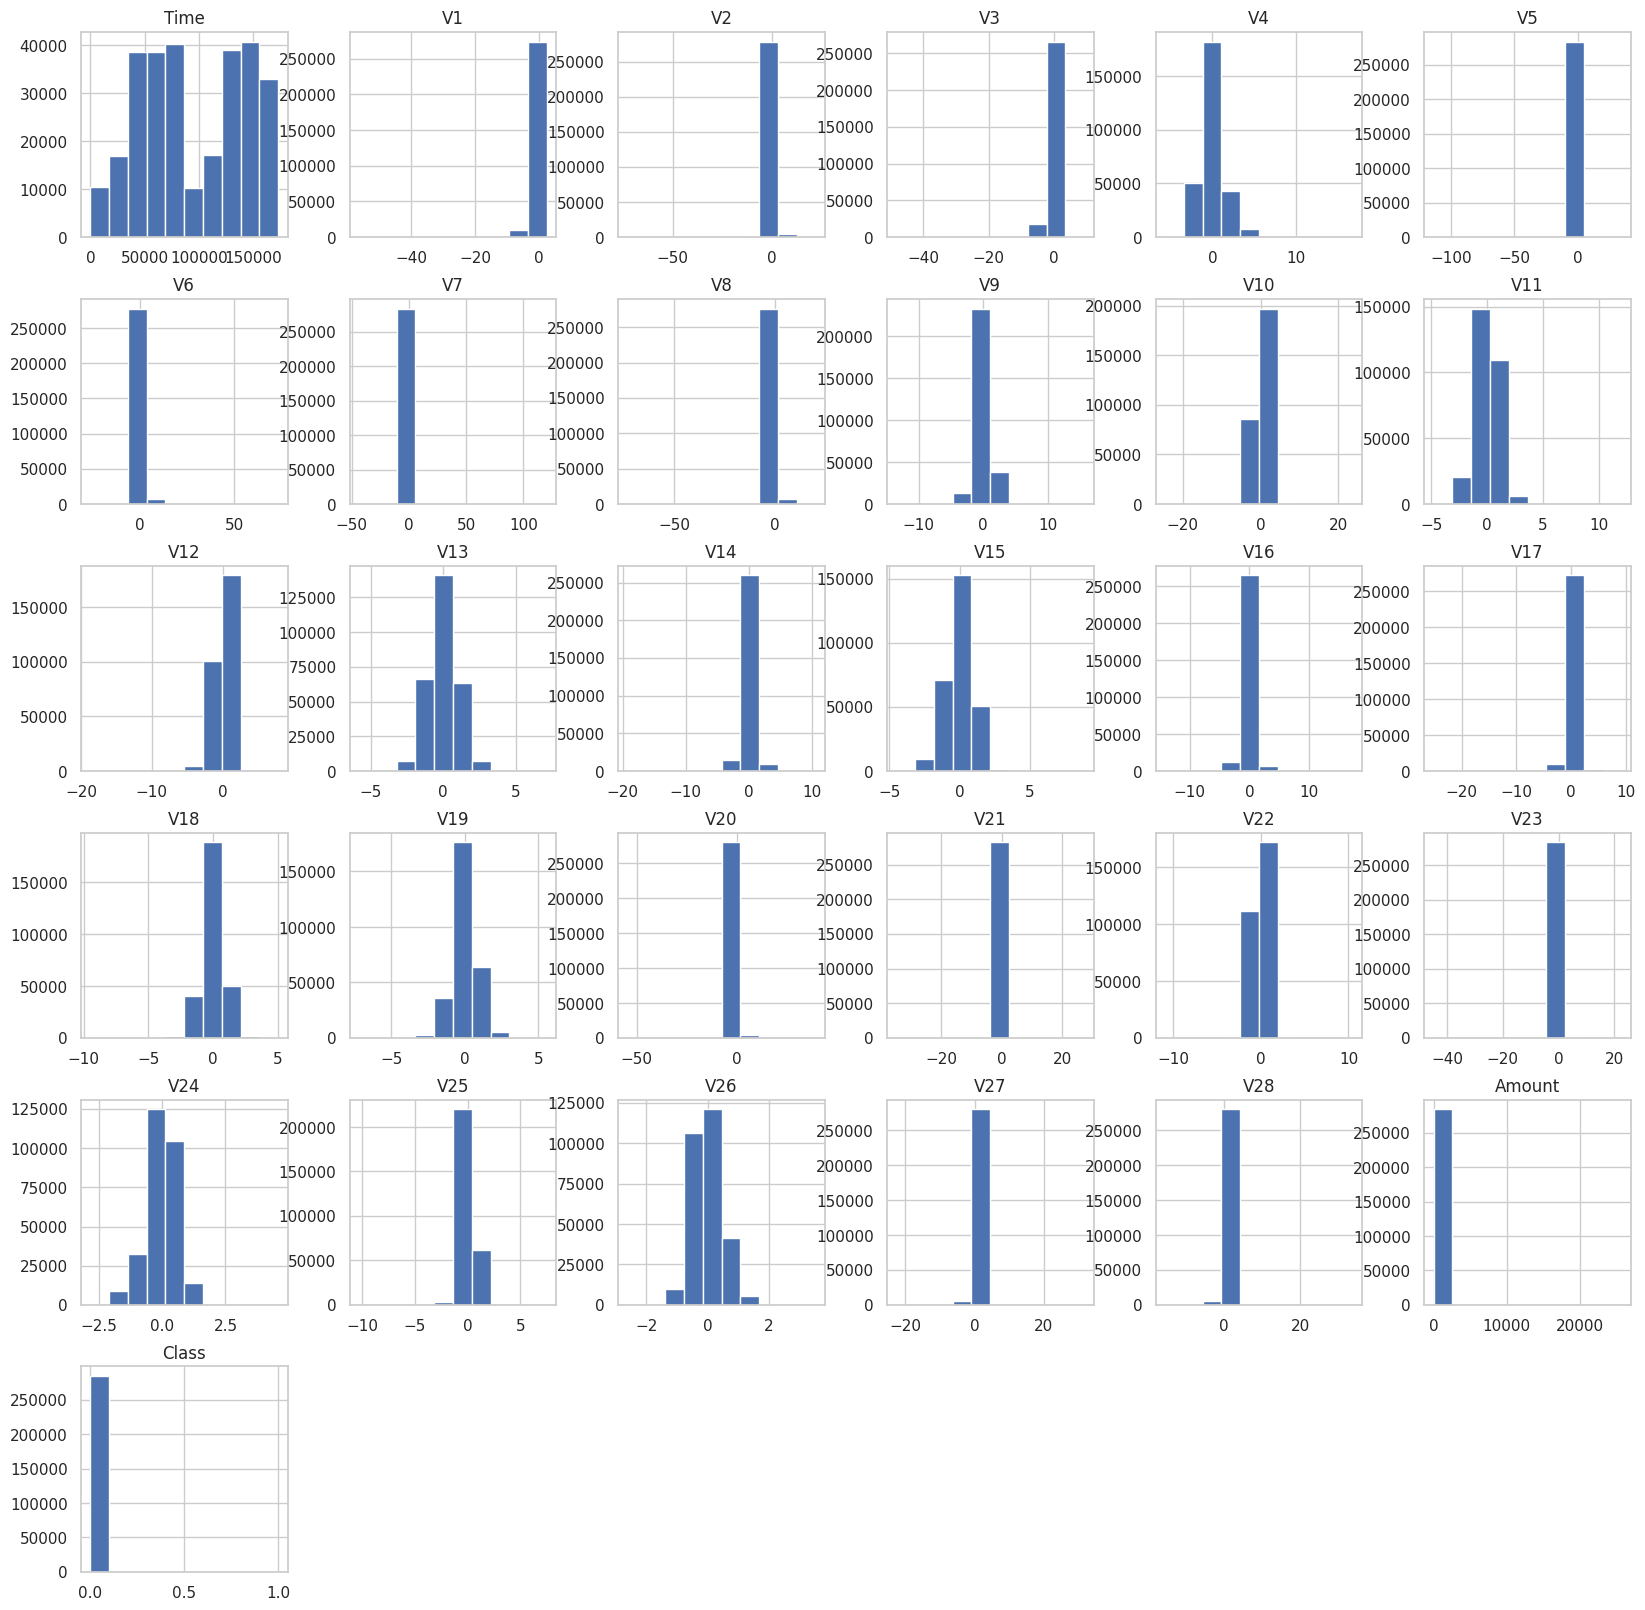

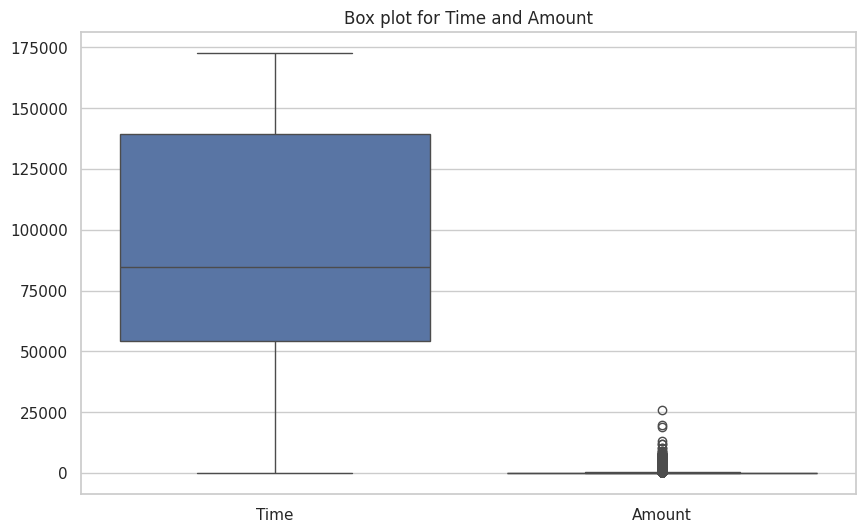

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Histograms for all features
df.hist(figsize=(20,20))
plt.show()

# Box-plots for 'Amount' and 'Time' as they are not transformed by PCA
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Time', 'Amount']])
plt.title('Box plot for Time and Amount')
plt.show()


## Data cleaning
Since there is dirty data in the dataset, not data cleaning is needed.

## Data Transformation



In [8]:
from sklearn.preprocessing import StandardScaler
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape (-1,1))
df = df.drop (['Time', 'Amount'], axis = 1);

In [9]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313249


In [10]:
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']

In [11]:
y['Class'].unique()

array([0, 1])

### Model Building and Training:

#### Choice of unsupervised learning models:

For the Credit Card Fraud Detection dataset, we can explore several unsupervised learning models to identify potential fraudulent transactions. Here are some models we might consider:




### K-Means Clustering
 This algorithm partitions the data into K distinct clusters based on feature similarity. For fraud detection, we could use K-Means to group transactions and identify clusters that may correspond to unusual or suspicious activities.

We know already that we have only two clusters: legit and Fraud.

In [12]:
from sklearn.cluster import KMeans

# we know we have only two clusters
n_clusters = 2

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)


KMeans(n_clusters=2, n_init=10, random_state=0)

In [11]:
# Predict the cluster labels
labels = kmeans.predict(X)

In [12]:
labels

array([1, 0, 1, ..., 0, 1, 1], dtype=int32)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y, labels))
print(classification_report(y, labels))


[[134611 149704]
 [   134    358]]
              precision    recall  f1-score   support

           0       1.00      0.47      0.64    284315
           1       0.00      0.73      0.00       492

    accuracy                           0.47    284807
   macro avg       0.50      0.60      0.32    284807
weighted avg       1.00      0.47      0.64    284807



In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y, labels)
print('Accuracy:', accuracy)


Accuracy: 0.4738963578844621


## Isolation Forest:
The Isolation Forest algorithm is an efficient method for anomaly detection, especially suited for high-dimensional datasets. It belongs to a class of ensemble methods and is based on the principle that anomalies are data points that are few and different. As a result, it will be easier to isolate these points from the rest of the data compared to normal points.

### Principle:
The core idea behind the Isolation Forest is that anomalies can be isolated closer to the root of the tree (with fewer splits) compared to normal points. An Isolation Forest builds an ensemble of Isolation Trees for the given data points. In these trees, the data points are recursively partitioned by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

### Parameters:
The key parameters in an Isolation Forest are:

- `n_estimators`: The number of base estimators (trees) in the ensemble. Typically, more trees will require more time to train but will lead to more reliable anomaly score estimates.
- `max_samples`: The number of samples to draw from the dataset to train each base estimator. If you're dealing with very large datasets, reducing this number can speed up the training process without a significant impact on the anomaly detection performance.
- `contamination`: The proportion of outliers in the data set, used to define the threshold on the scores of the instances. If known, setting this parameter can improve the performance of the detector.


In [13]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)

# Fit the model
iso_forest.fit(X)

IsolationForest(random_state=42)

In [17]:
# Predict anomalies (-1 for anomalies, 1 for normal)
labels = iso_forest.predict(X)

# The anomaly score of the input samples (the lower, the more abnormal)
scores = iso_forest.decision_function(X)

# Detecting outliers and normal points
outliers = X[labels == -1]
normal = X[labels == 1]

In [27]:
is_anomaly = np.where(labels == -1, 1, 0)

In [28]:
is_anomaly

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
print(confusion_matrix(y, is_anomaly))
print(classification_report(y, is_anomaly))

[[274629   9686]
 [    90    402]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    284315
           1       0.04      0.82      0.08       492

    accuracy                           0.97    284807
   macro avg       0.52      0.89      0.53    284807
weighted avg       1.00      0.97      0.98    284807



In [29]:
accuracy = accuracy_score(y, is_anomaly)
print('Accuracy:', accuracy)


Accuracy: 0.9656750009655661


## Local Outlier Factor (LOF)
The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.



In [31]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

# Initialize the LOF model
# Note: n_neighbors can be chosen based on the dataset; a small value is more sensitive to outliers.
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Fit the model and predict anomalies (1 for normal, -1 for anomaly)
labels = lof.fit_predict(X)

# The negative outlier factor (the lower, the more abnormal)
negative_factors = lof.negative_outlier_factor_

# Since the scores are negative, we invert them by taking their absolute values
scores = -negative_factors  # Now, higher scores indicate more abnormal

# Convert labels: -1 (anomalies) to 1, and 1 (normal) to 0
is_anomaly = np.where(labels == -1, 1, 0)


In [32]:
print(confusion_matrix(y, is_anomaly))
print(classification_report(y, is_anomaly))

[[266481  17834]
 [   432     60]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    284315
           1       0.00      0.12      0.01       492

    accuracy                           0.94    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.94      0.97    284807



In [33]:
accuracy = accuracy_score(y, is_anomaly)
print('Accuracy:', accuracy)

Accuracy: 0.9358653403884034


## One-Class SVM

One-Class SVM (Support Vector Machine) is a type of SVM used for anomaly detection, rather than for classification tasks. The algorithm learns a decision function for novelty detection: it classifies new data as similar to the training set or different. In other words, it tries to separate all the data points from the origin in the feature space and maximizes the distance from this hyperplane to the origin. This results in capturing regions in the feature space where the probability density of the data resides.

In [34]:
from sklearn.svm import OneClassSVM

# Initialize the One-Class SVM model
# Note: nu is an upper bound on the fraction of outliers and a lower bound of the fraction of support vectors.
# gamma is a parameter of the RBF kernel (if you're using RBF kernel)
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)

# Fit the model
ocsvm.fit(X)

# Predict the anomalies (1 for normal, -1 for anomaly)
labels = ocsvm.predict(X)

# Convert labels: -1 (anomalies) to 1, and 1 (normal) to 0
is_anomaly = np.where(labels == -1, 1, 0)

In [35]:
print(confusion_matrix(y, is_anomaly))
print(classification_report(y, is_anomaly))

[[270502  13813]
 [    60    432]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.88      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



In [36]:
accuracy = accuracy_score(y, is_anomaly)
print('Accuracy:', accuracy)

Accuracy: 0.9512898208260331


# Conclusion
In our analysis, we explored several anomaly detection techniques: KMeans, Isolation Forest, Local Outlier Factor (LOF), and One-Class SVM. Each of these methods offers a different approach to identifying outliers or anomalies within a dataset, leveraging different principles from clustering to density estimation and support vector machines. Here's a summary and conclusion of our findings from applying each method:

1. **KMeans**: This clustering method was used as an indirect approach for anomaly detection. By partitioning the dataset into clusters, we could identify anomalies as those points that lie far from the centroids of their nearest clusters. While not inherently designed for anomaly detection, KMeans provided a baseline by highlighting data points that did not conform well to any cluster. However, it was not really effective as it had an accuracy of** 0.47** .

2. **Isolation Forest**: This method proved to be particularly effective for high-dimensional datasets, as it isolates anomalies rather than normal observations. It works on the principle that anomalies are few and different and thus are easier to 'isolate' compared to normal points. Isolation Forest was efficient and scalable, providing a good balance between detecting global and local anomalies. However, its performance heavily depends on parameters like `n_estimators` and `contamination`. For our analysis it had an accuracy of **0.9656750009655661** .

3. **Local Outlier Factor (LOF)**: LOF was useful in detecting anomalies that vary in density relative to their neighbors. It’s an unsupervised algorithm that considers the local density deviation of a given data point with respect to its neighbors, offering nuanced insights, especially in datasets where anomalies are contextually defined (e.g., a point might be considered normal in one region of the space but an anomaly in another). While powerful, LOF's performance can degrade in higher-dimensional spaces due to the curse of dimensionality. It had an accuracy of 0.9358653403884034 .

4. **One-Class SVM**: This method approached anomaly detection from a different angle, attempting to define a boundary around the data points considered 'normal'. One-Class SVM is particularly suited for situations where the dataset has a clear notion of what constitutes normal behavior, but can be sensitive to the choice of kernel and the `nu` parameter. It performed well in capturing the shape of the data distribution, but like LOF, it might struggle with high-dimensional data unless combined with dimensionality reduction techniques. The accuracy for this model is 0.9512898208260331.

### General Conclusion:
Through this analysis, we observed that no single anomaly detection technique universally outperforms others across all types of data. The effectiveness of each method varies depending on the nature of the dataset (e.g., dimensionality, distribution, density), the type of anomalies (global vs. local), and the specific domain requirements.

- For high-dimensional datasets, Isolation Forest generally provided good performance with less parameter tuning.
- LOF offered valuable insights for datasets where anomaly detection relies more on local context.
- One-Class SVM was useful for datasets where we could clearly define what constitutes normal behavior but required careful selection of parameters.
- KMeans served as a simple, intuitive baseline for anomaly detection, although it's typically less sophisticated compared to the other methods.

Ultimately, the choice of the anomaly detection method should be guided by the specific characteristics of the dataset and the particular requirements of the task at hand. In many real-world applications, a combination of these techniques, along with domain expertise, is often necessary to effectively identify and interpret anomalies. Experimentation and validation are key components of any anomaly detection task, and results should always be interpreted with an understanding of the underlying data and the context of the analysis.